# CLIP (Contrastive Language-Image Pre-training))
[A. Radford, J. W. Kim, C. Hallacy, et al., "Learning Transferable Visual Models from Natural Language Supervision" arXiv, 2021.](https://arxiv.org/abs/2103.00020)

* New approch to link images and texts, enabling scalable supervised learning by using natural language

* Contrastive pre-training
  1. Extract feature representations of each modality.
```
I_f = image_encoder(image) # [N, D_i]
T_f = text_encoder(text)   # [N, D_t]
```
```
I_e = l2_normalize(np.dot(I_f, W_i), axis=1)
T_e = l2_normalize(np.dot(T_f, W_t), axis=1)
```

  2. Calculate the cosin similarity for each pair.
```
logits = np.dot(I_e, T_e.T) * np.exp(t)  # [N, N]
```

  3. Campute the cross-entropy using symmetric loss function.
```
labels = np.arange(n)
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2
```

* Zero-shot prediction
  1. Create a list of label text: `A phost of a {class_name}`
  2. Extract feature representations from input images and the above text list<br>
     and calculate the similarity for each label text
  3. Pick the text with highest score as the answer


In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
DRIVE_ROOT = Path('/content/drive/MyDrive')

DATA_ROOT= Path('./data/')
MODEL_ROOT = DRIVE_ROOT / 'weights'

!mkdir -p {DATA_ROOT}
!mkdir -p {MODEL_ROOT}

Mounted at /content/drive


In [2]:
%pip install -q matplotlib torchviz torchinfo
%pip -q install "git+https://github.com/openai/CLIP.git"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
from torchvision import datasets, models, ops, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

def get_device():
    '''Get device (CPU or GPU).'''
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Quick Hands-on with CLIP Zero-shot Prediction

In [4]:
def visualize(image, texts, scores, figsize=(6,3), topk=5):
    top_scores, top_idx = scores.topk(topk)

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 2], wspace=0.05)

    ax_img = fig.add_subplot(gs[0])
    ax_img.imshow(image)
    ax_img.axis("off")

    ax_txt = fig.add_subplot(gs[1])
    captions = [
        f"Ground Truth:",
        texts[label],
        '\n',
        'Prediction:',
    ] + [f"{i+1}. {texts[top_idx[i]]}: {top_scores[i]:.2f}" for i in range(topk)]
    ax_txt.text(0, 1, '\n'.join(captions), ha="left", va="top")
    ax_txt.axis("off")

    plt.show()

In [5]:
!rsync -auv {DRIVE_ROOT}/datasets/food-101.tar.gz {DATA_ROOT}/

sending incremental file list
food-101.tar.gz

sent 4,997,498,228 bytes  received 35 bytes  72,956,179.02 bytes/sec
total size is 4,996,278,331  speedup is 1.00


In [6]:
# Set up the today dataset.
dataset = datasets.Food101(root=DATA_ROOT, download=True)
classes = dataset.classes

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 182MiB/s]


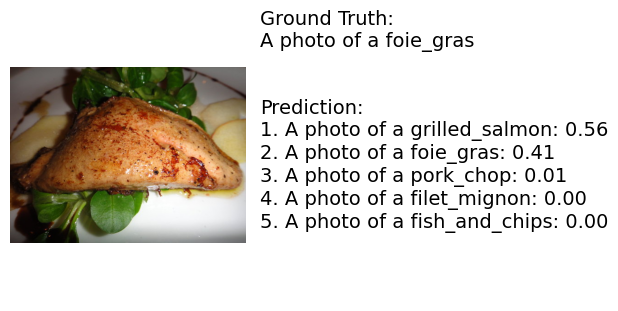

In [7]:
import clip
import random
from PIL import Image

# Pick a pair of image and text randomly.
rand_idx = random.randrange(len(dataset))
image, label = dataset[rand_idx]

# Set up a CLIP model.
device = get_device()
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

with torch.inference_mode():
    # Extract feature representations of input image.
    image_t = preprocess(image).unsqueeze(0).to(device)  # [1, C, H, W]
    image_f = model.encode_image(image_t)                # [1, D]
    image_f /= image_f.norm(dim=-1, keepdim=True)

    # Extract feature representations of input text
    texts = [f"A photo of a {class_name}" for class_name in classes]
    tokens = clip.tokenize(texts).to(device)  # [N_class, token_length]
    texts_f = model.encode_text(tokens)       # [N_class, D]
    texts_f /= texts_f.norm(dim=-1, keepdim=True)

    # Compute the cosine similarity between the encoded image and text.
    scale_factor = model.logit_scale.exp()
    logits = (image_f @ texts_f.T).squeeze(0) * scale_factor  # [N_class]
    scores = logits.softmax(dim=-1)                           # [N_class]

visualize(image, texts, scores)

## Contrastive pre-training